# Dual Moons likelihood

Dual moons is a tricky likelihood that mimics physically challenging models.

In [1]:

import os

os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=6"
from jax import config

config.update("jax_enable_x64", True)

import pylab as plt
import tensorflow_probability.substrates.jax as tfp
from jax import random, numpy as jnp
from jax import vmap

from jaxns import DefaultNestedSampler
from jaxns import Model
from jaxns import Prior
from jaxns import bruteforce_evidence

tfpd = tfp.distributions

INFO[2023-12-21 13:21:14,511]: Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO[2023-12-21 13:21:14,511]: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO[2023-12-21 13:21:14,512]: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
WARNING[2023-12-21 13:21:14,513]: An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [2]:
from jax._src.scipy.special import logsumexp


def log_likelihood(x):
    """
    Dual moon log-likelihood.
    """

    def fasym(t):
        return jnp.piecewise(
            t, [t < 0, t >= 0],
            [lambda x: (x / 2) ** 2,
             lambda x: (x / 0.5) ** 4
             ])

    xx = x[..., :1]
    xy = x[..., 1:2]
    rho1 = jnp.sqrt((xx) ** 2 + (xy) ** 2)
    theta1 = jnp.arctan2(xy, xx)
    term1 = ((rho1 - 2) / 0.05) ** 2
    term2 = fasym(theta1 - jnp.pi / 2) / 0.2

    rho2 = jnp.sqrt((xx) ** 2 + (xy) ** 2)
    theta2 = jnp.arctan2(xy, xx)
    term12 = ((rho2 - 2) / 0.05) ** 2
    term22 = fasym(theta1 + jnp.pi / 3) / 0.2

    pe = logsumexp(-jnp.stack([term1 + term2, term12 + term22]), axis=0)

    return pe.squeeze()


def prior_model():
    x = yield Prior(tfpd.Uniform(low=-4 * jnp.ones(2), high=4. * jnp.ones(2)), name='x')
    return x


model = Model(prior_model=prior_model,
              log_likelihood=log_likelihood)

log_Z_true = bruteforce_evidence(model=model, S=250)
print(f"True log(Z)={log_Z_true}")


True log(Z)=-5.104862238439268


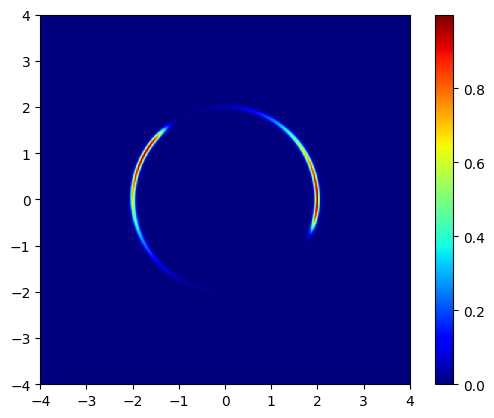

In [3]:

u_vec = jnp.linspace(0., 1., 250)
args = jnp.stack([x.flatten() for x in jnp.meshgrid(*[u_vec] * model.U_ndims, indexing='ij')], axis=-1)

# The `prepare_func_args(log_likelihood)` turns the log_likelihood into a function that nicely accepts **kwargs
lik = vmap(model.forward)(args).reshape((u_vec.size, u_vec.size))

plt.imshow(jnp.exp(lik), origin='lower', extent=(-4, 4, -4, 4), cmap='jet')
plt.colorbar()
plt.show()

In [4]:


# Create the nested sampler class. In this case without any tuning.
ns = DefaultNestedSampler(model=model, max_samples=1e5)

termination_reason, state = ns(random.PRNGKey(42))
results = ns.to_results(termination_reason=termination_reason, state=state)


In [5]:
# We can use the summary utility to display results
ns.summary(results)

--------
Termination Conditions:
Small remaining evidence
--------
likelihood evals: 64753
samples: 1680
phantom samples: 720
likelihood evals / sample: 38.5
phantom fraction (%): 42.9%
--------
logZ=-5.07 +- 0.33
H=-4.12
ESS=125
--------
x[#]: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
x[0]: 0.45 +- 0.72 | -0.46 / 0.53 / 1.35 | 1.03 | 1.03
x[1]: 0.0 +- 1.8 | -2.0 / 1.0 / 2.0 | -1.7 | -1.7
--------


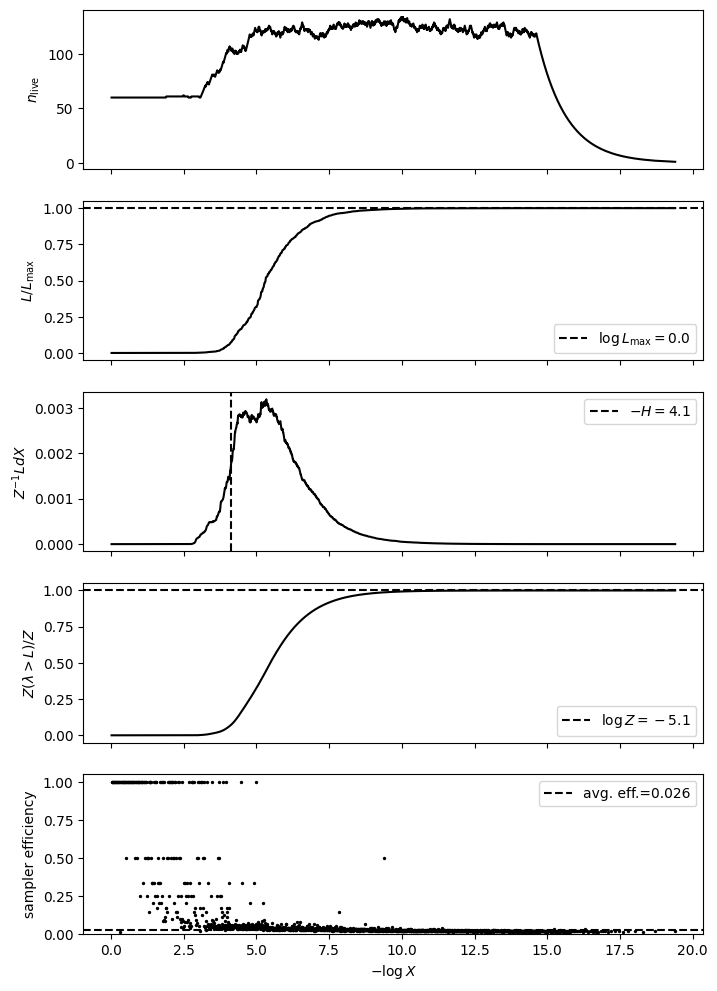

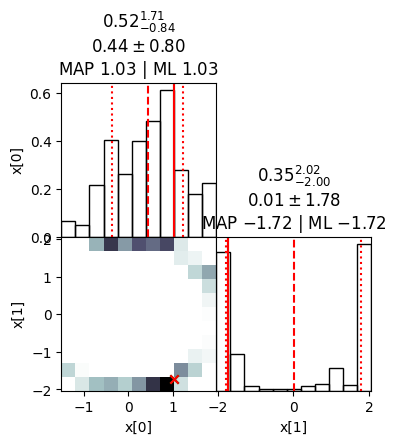

In [6]:
# We plot useful diagnostics and a distribution cornerplot
ns.plot_diagnostics(results)
ns.plot_cornerplot(results)